# Clean up for your vacation images

In [1]:
# Define global variables, are explained below

IMAGES = './images/' # path to the images
IMAGES_PREPROCESSED = './preprocessed/' # not used at the moment
IMAGES_PROCESSED = './processed/' # output destination
HASH_DIM = (8, 8)

In [2]:
import glob
import os
import shutil

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as sts
from sklearn.linear_model import LogisticRegression

import spring_cleaning as sc # outsourced code

In [3]:
# Load images and meta data

dict_files = sc.read_files(path=IMAGES, ext='jpg')

df = pd.DataFrame(dict_files, columns=['file', 'creation_date'])
df['creation_date'] = pd.to_numeric(df['creation_date'], downcast='integer')

# For ranking of images, we need some intrinsic measure for consecutiveness
# 'Creation Date' of images is a good measure
# 'File Name' as well, if pictures are taken from one and the same camera

# alternatively, sort by Filename: df.sort_values(by=['File'])
df = df.sort_values(by=['creation_date'])
df['timediff_value'] = df['creation_date'].diff(-1).abs()

# Load images
df['gray_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='gray')) 
                                            for cur_file in df['file'].values]
df['hsv_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='hsv')) 
                                            for cur_file in df['file'].values]
df['rgb_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='rgb')) 
                                            for cur_file in df['file'].values]

df = df.assign(target = df['file'].str.split(n=0, pat='_', expand=True).loc[:, 0])
df['target'], _ = pd.factorize(df['target'])
df['target'] = df['target'] + 1

df[[c for c in df.columns if not c.endswith('_images')]].head()

,file,creation_date,timediff_value,target
23,ar_1.JPG,1487935036,0.0,1
22,ar_0.JPG,1487935036,16.0,1
25,as_1.JPG,1487935052,0.0,2
24,as_0.JPG,1487935052,10.0,2
26,at_0.JPG,1487935062,2.0,3


# Bootstrap to augment sample size

In [4]:
res = sc.bootstrap_data(df, n_runs=10)
res[0].columns

Index(['target', 'creation_date', 'hash_value', 'hash_value_adv',
       'correl_corr', 'bhattacharyya_corr', 'avg_hash_value_cmp',
       'block_hash_value_cmp', 'phash_value_cmp',
       'marr_hildreth_hash_value_cmp', 'radial_variance_hash_value_cmp'],
      dtype='object')

# Method 1: Estimate mean values

## For Hashing

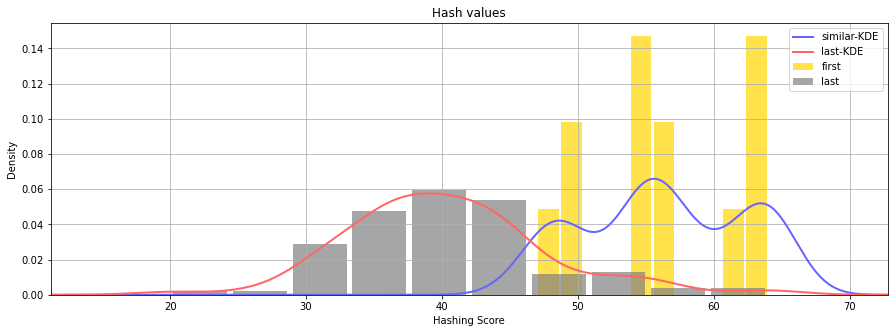

Mean value for groups: 56.33 +- 5.79
Mean value for non-groups: 40.32 +- 7.30

Performance report
--------------------------------------------------
True positive: 60 -- False negative: 60
True negative: 184 -- False positive: 6

Precision score: 0.9091
Recall score: 0.5000
F1 score: 0.6452


In [5]:
summary = {}

nonsimilar_hash = sc.return_dist(res, _type='nonsimilar', 
                                 target_col='target', comp_col='hash_value')
similar_hash = sc.return_dist(res, _type='similar', 
                              target_col='target', comp_col='hash_value')

sc.plot_distributions(similar_hash, nonsimilar_hash, 
                      labels=('Hashing Score', 'Density'), title='Hash values')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(
    similar_hash.mean(), similar_hash.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}\n'.format(
    nonsimilar_hash.mean(), nonsimilar_hash.std()))

summary.update({'hash_1':
        sc.performance_report(similar_hash, nonsimilar_hash, limit=56.33)})

## For Advanced Hashing

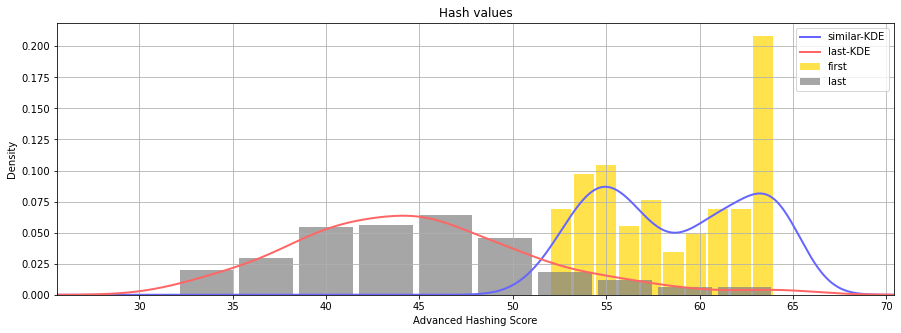

Mean value for groups: 58.72 +- 4.09
Mean value for non-groups: 44.78 +- 6.36

Performance report
--------------------------------------------------
True positive: 62 -- False negative: 58
True negative: 184 -- False positive: 6

Precision score: 0.9118
Recall score: 0.5167
F1 score: 0.6596


In [6]:
nonsimilar_hash_adv = sc.return_dist(res, _type='nonsimilar', 
                                 target_col='target', comp_col='hash_value_adv')
similar_hash_adv = sc.return_dist(res, _type='similar', 
                              target_col='target', comp_col='hash_value_adv')

sc.plot_distributions(similar_hash_adv, nonsimilar_hash_adv, 
                      labels=('Advanced Hashing Score', 'Density'), title='Hash values')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(
    similar_hash_adv.mean(), similar_hash_adv.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}\n'.format(
    nonsimilar_hash_adv.mean(), nonsimilar_hash_adv.std()))

summary.update({'hash_adv_1':
        sc.performance_report(similar_hash_adv, nonsimilar_hash_adv, limit=58.72)})

## For Bhattacharyya correlation

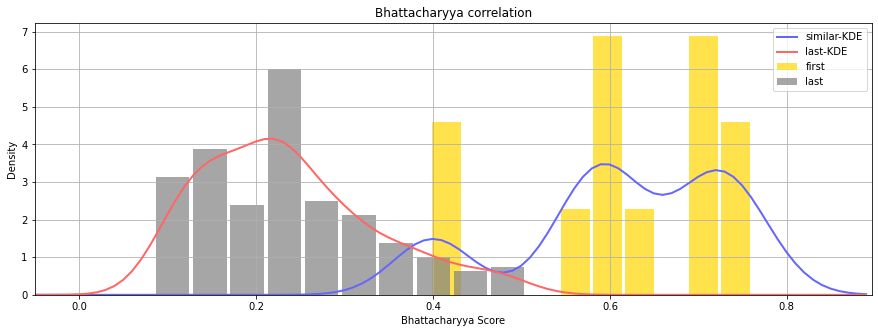

Mean value for groups: 0.61 +- 0.12
Mean value for non-groups: 0.24 +- 0.10

Performance report
--------------------------------------------------
True positive: 60 -- False negative: 60
True negative: 190 -- False positive: 0

Precision score: 1.0000
Recall score: 0.5000
F1 score: 0.6667


In [7]:
nonsimilar_bhatt = sc.return_dist(res, _type='nonsimilar', 
                                 target_col='target', comp_col='bhattacharyya_corr')
similar_bhatt = sc.return_dist(res, _type='similar', 
                                  target_col='target', comp_col='bhattacharyya_corr')

sc.plot_distributions(similar_bhatt, nonsimilar_bhatt, 
                   labels=('Bhattacharyya Score', 'Density'),
                   title='Bhattacharyya correlation')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(
    similar_bhatt.mean(), similar_bhatt.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}\n'.format(
    nonsimilar_bhatt.mean(), nonsimilar_bhatt.std()))

summary.update({'bhattacharyya_1': 
            sc.performance_report(similar_bhatt, nonsimilar_bhatt, limit=0.61)})

## For plain correlation

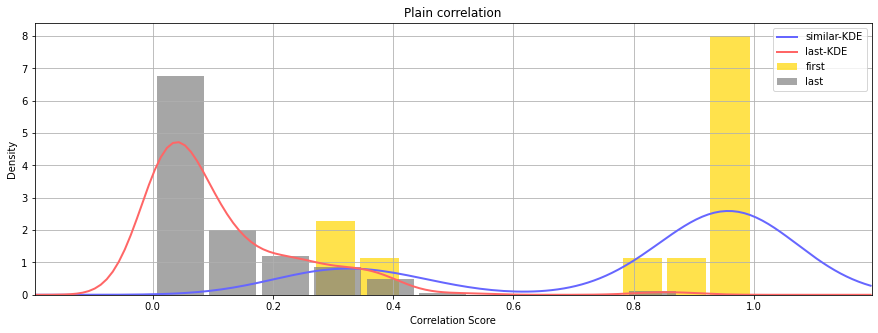

Mean value for groups: 0.80 +- 0.27
Mean value for non-groups: 0.12 +- 0.14

Performance report
--------------------------------------------------
True positive: 90 -- False negative: 30
True negative: 188 -- False positive: 2

Precision score: 0.9783
Recall score: 0.7500
F1 score: 0.8491


In [8]:
nonsimilar_corr = sc.return_dist(res, _type='nonsimilar', 
                                 target_col='target', comp_col='correl_corr')
similar_corr = sc.return_dist(res, _type='similar', 
                                  target_col='target', comp_col='correl_corr')

sc.plot_distributions(similar_corr, nonsimilar_corr, 
                   labels=('Correlation Score', 'Density'),
                   title='Plain correlation')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(
    similar_corr.mean(), similar_corr.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}\n'.format(
    nonsimilar_corr.mean(), nonsimilar_corr.std()))

summary.update({'correl_1': 
                sc.performance_report(similar_corr, nonsimilar_corr, limit=0.8)})

## For average hashing (cv2)

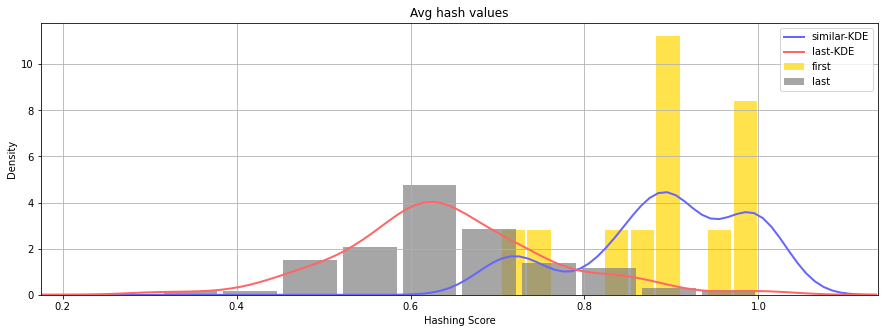

Mean value for groups: 0.89 +- 0.09
Mean value for non-groups: 0.64 +- 0.12

Performance report
--------------------------------------------------
True positive: 80 -- False negative: 40
True negative: 184 -- False positive: 6

Precision score: 0.9302
Recall score: 0.6667
F1 score: 0.7767


In [9]:
nonsimilar_hash_avg = sc.return_dist(res, _type='nonsimilar', 
                                 target_col='target', comp_col='avg_hash_value_cmp')
similar_hash_avg = sc.return_dist(res, _type='similar', 
                              target_col='target', comp_col='avg_hash_value_cmp')

sc.plot_distributions(similar_hash_avg, nonsimilar_hash_avg, 
                      labels=('Hashing Score', 'Density'), title='Avg hash values')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(
    similar_hash_avg.mean(), similar_hash_avg.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}\n'.format(
    nonsimilar_hash_avg.mean(), nonsimilar_hash_avg.std()))

summary.update({'avg_hash_1':
        sc.performance_report(similar_hash_avg, nonsimilar_hash_avg, limit=0.89)})

## For block mean hashing

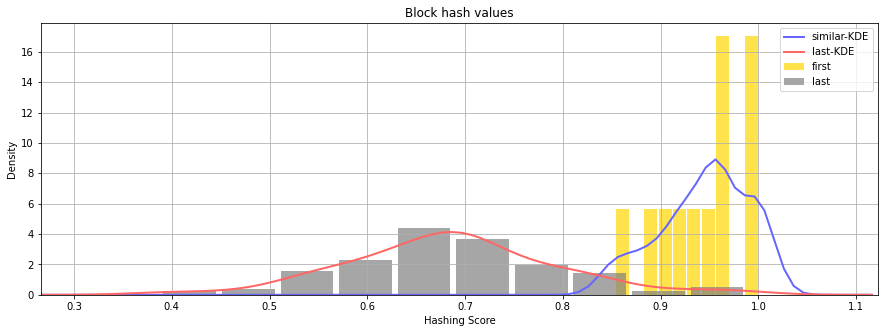

Mean value for groups: 0.94 +- 0.04
Mean value for non-groups: 0.69 +- 0.11

Performance report
--------------------------------------------------
True positive: 70 -- False negative: 50
True negative: 186 -- False positive: 4

Precision score: 0.9459
Recall score: 0.5833
F1 score: 0.7216


In [10]:
nonsimilar_hash_block = sc.return_dist(res, _type='nonsimilar', 
                                 target_col='target', comp_col='block_hash_value_cmp')
similar_hash_block = sc.return_dist(res, _type='similar', 
                              target_col='target', comp_col='block_hash_value_cmp')

sc.plot_distributions(similar_hash_block, nonsimilar_hash_block, 
                      labels=('Hashing Score', 'Density'), title='Block hash values')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(
    similar_hash_block.mean(), similar_hash_block.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}\n'.format(
    nonsimilar_hash_block.mean(), nonsimilar_hash_block.std()))

summary.update({'block_hash_1':
        sc.performance_report(similar_hash_block, nonsimilar_hash_block, limit=0.94)})

## For perceptual hashing

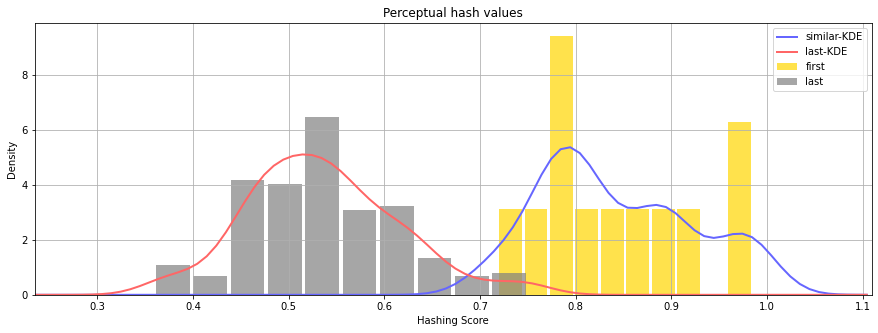

Mean value for groups: 0.84 +- 0.08
Mean value for non-groups: 0.54 +- 0.08

Performance report
--------------------------------------------------
True positive: 50 -- False negative: 70
True negative: 190 -- False positive: 0

Precision score: 1.0000
Recall score: 0.4167
F1 score: 0.5882


In [11]:
nonsimilar_hash_p = sc.return_dist(res, _type='nonsimilar', 
                                 target_col='target', comp_col='phash_value_cmp')
similar_hash_p = sc.return_dist(res, _type='similar', 
                              target_col='target', comp_col='phash_value_cmp')

sc.plot_distributions(similar_hash_p, nonsimilar_hash_p, 
                      labels=('Hashing Score', 'Density'), title='Perceptual hash values')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(
    similar_hash_p.mean(), similar_hash_p.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}\n'.format(
    nonsimilar_hash_p.mean(), nonsimilar_hash_p.std()))

summary.update({'perceptual_hash_1':
        sc.performance_report(similar_hash_p, nonsimilar_hash_p, limit=0.84)})

## For Marr Hildreth hashing

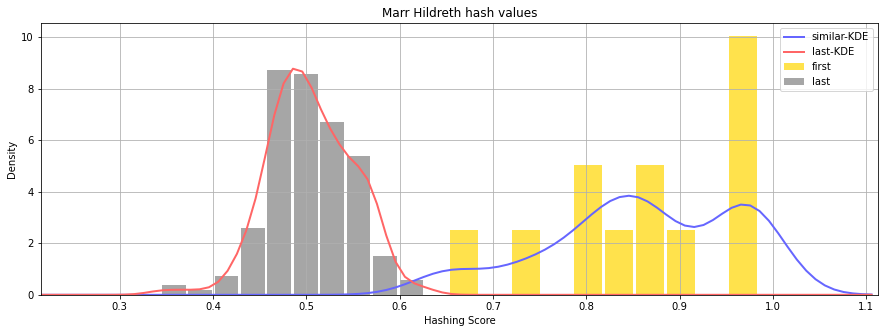

Mean value for groups: 0.86 +- 0.10
Mean value for non-groups: 0.50 +- 0.04

Performance report
--------------------------------------------------
True positive: 60 -- False negative: 60
True negative: 190 -- False positive: 0

Precision score: 1.0000
Recall score: 0.5000
F1 score: 0.6667


In [12]:
nonsimilar_hash_mh = sc.return_dist(res, _type='nonsimilar', 
                                 target_col='target', comp_col='marr_hildreth_hash_value_cmp')
similar_hash_mh = sc.return_dist(res, _type='similar', 
                              target_col='target', comp_col='marr_hildreth_hash_value_cmp')

sc.plot_distributions(similar_hash_mh, nonsimilar_hash_mh, 
                      labels=('Hashing Score', 'Density'), title='Marr Hildreth hash values')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(
    similar_hash_mh.mean(), similar_hash_mh.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}\n'.format(
    nonsimilar_hash_mh.mean(), nonsimilar_hash_mh.std()))

summary.update({'marrhildreth_hash_1':
        sc.performance_report(similar_hash_mh, nonsimilar_hash_mh, limit=0.86)})

## For radial variance hashing

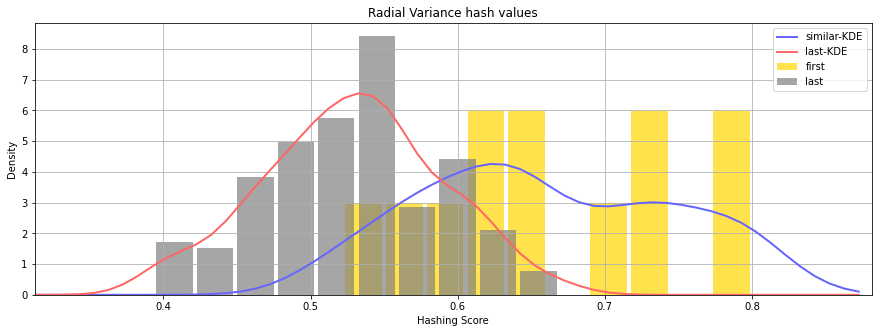

Mean value for groups: 0.66 +- 0.08
Mean value for non-groups: 0.53 +- 0.06

Performance report
--------------------------------------------------
True positive: 50 -- False negative: 70
True negative: 188 -- False positive: 2

Precision score: 0.9615
Recall score: 0.4167
F1 score: 0.5814


In [13]:
nonsimilar_hash_rv = sc.return_dist(res, _type='nonsimilar', 
                                 target_col='target', comp_col='radial_variance_hash_value_cmp')
similar_hash_rv = sc.return_dist(res, _type='similar', 
                              target_col='target', comp_col='radial_variance_hash_value_cmp')

sc.plot_distributions(similar_hash_rv, nonsimilar_hash_rv, 
                      labels=('Hashing Score', 'Density'), title='Radial Variance hash values')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(
    similar_hash_rv.mean(), similar_hash_rv.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}\n'.format(
    nonsimilar_hash_rv.mean(), nonsimilar_hash_rv.std()))

summary.update({'radialvariance_hash_1':
        sc.performance_report(similar_hash_rv, nonsimilar_hash_rv, limit=0.66)})

# Method 2: Logistic Regression fit

## For hashing

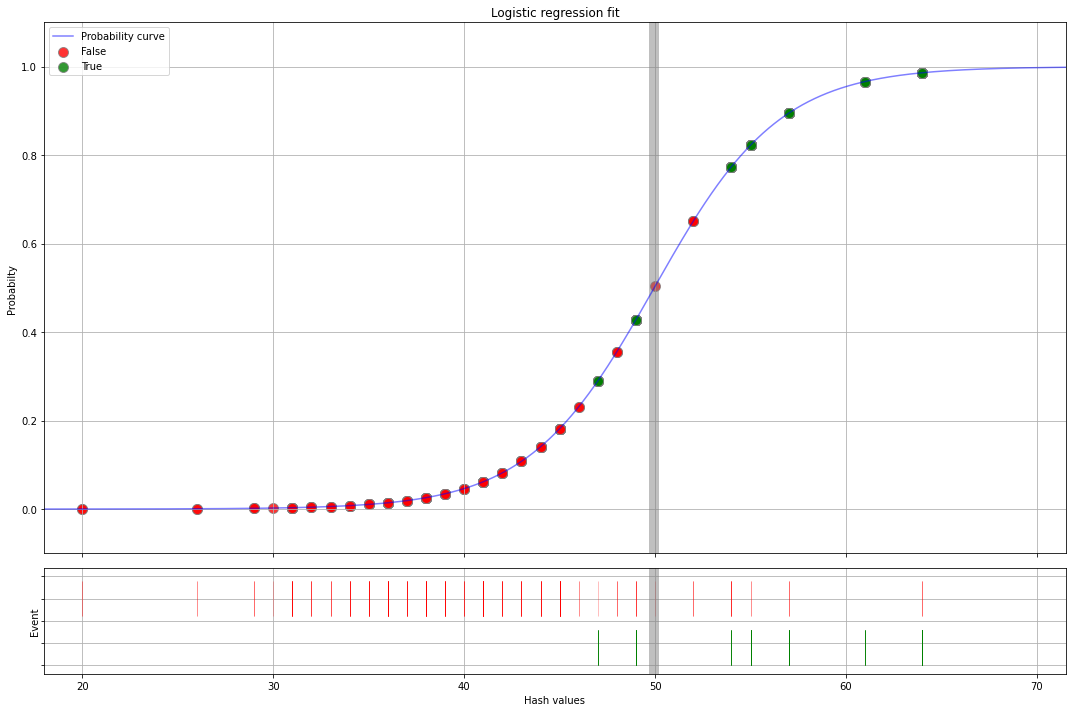

Limit at 49.95
Performance report
--------------------------------------------------
True positive: 90 -- False negative: 30
True negative: 172 -- False positive: 18

Precision score: 0.8333
Recall score: 0.7500
F1 score: 0.7895


In [14]:
sc.make_logreg_fit(similar_hash, nonsimilar_hash, 
                   labels=('Hash values', 'Probabilty'), limits=(20, 65))

summary.update({'hash_2':
            sc.performance_report(similar_hash, nonsimilar_hash, limit=49.95)})

## For advanced hashing

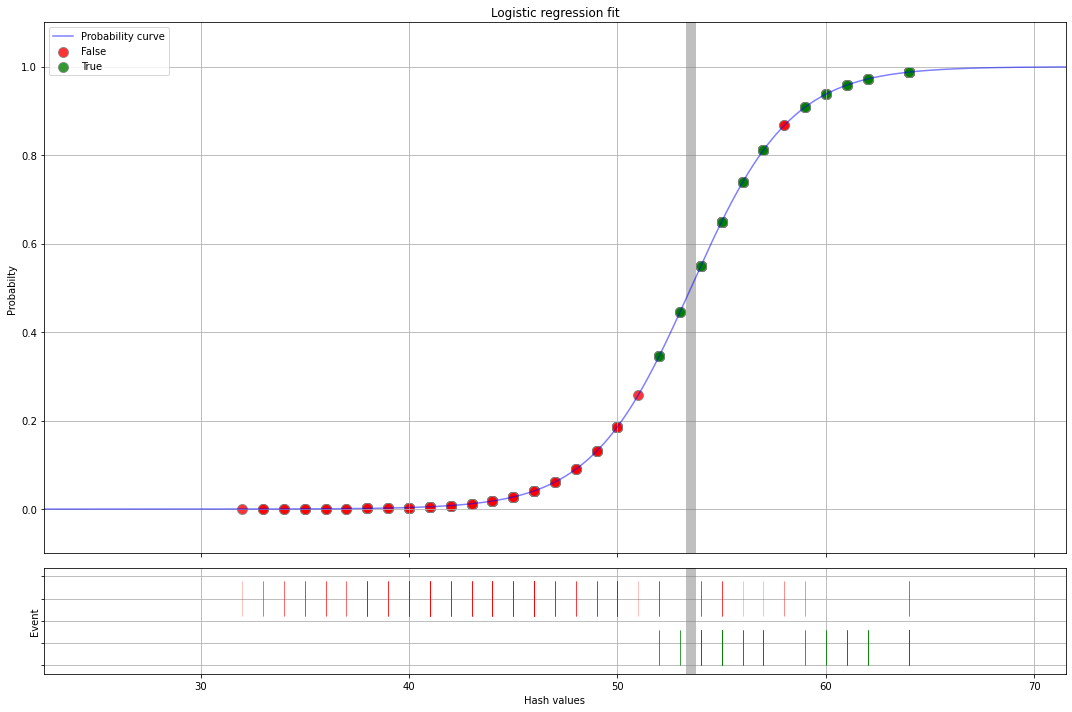

Limit at 53.53
Performance report
--------------------------------------------------
True positive: 90 -- False negative: 30
True negative: 176 -- False positive: 14

Precision score: 0.8654
Recall score: 0.7500
F1 score: 0.8036


In [15]:
sc.make_logreg_fit(similar_hash_adv, nonsimilar_hash_adv, 
                   labels=('Hash values', 'Probabilty'), limits=(25, 65))

summary.update({'hash_adv_2':
            sc.performance_report(similar_hash, nonsimilar_hash, limit=53.53)})

## For Bhattacharyya correlation

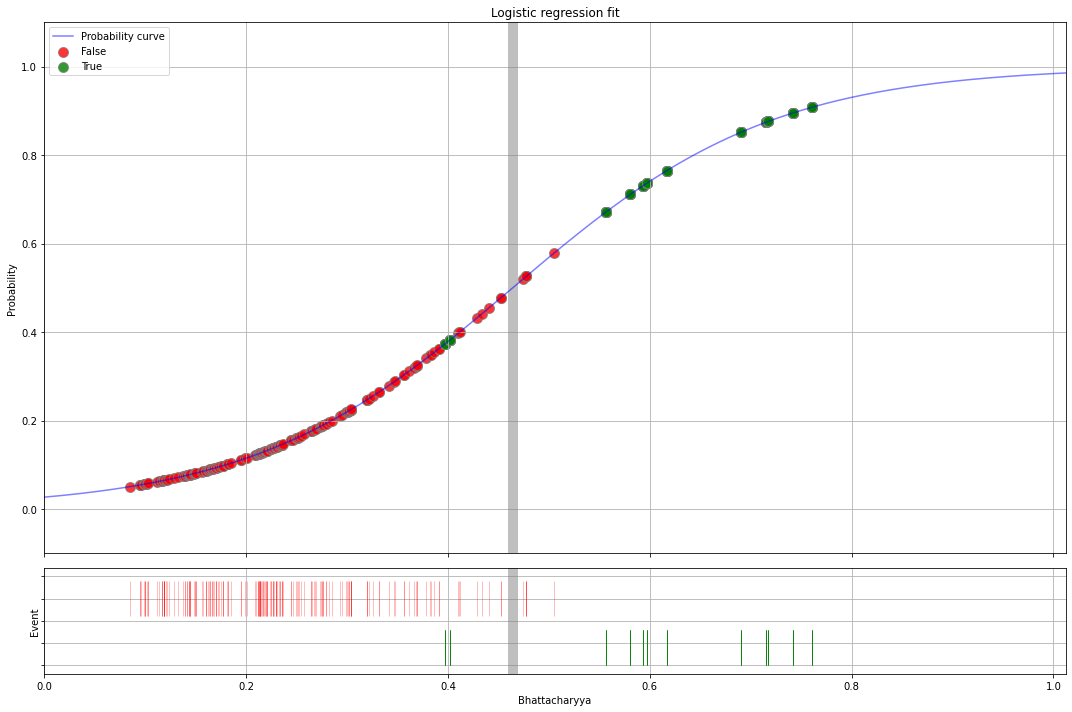

Limit at 0.46
Performance report
--------------------------------------------------
True positive: 100 -- False negative: 20
True negative: 184 -- False positive: 6

Precision score: 0.9434
Recall score: 0.8333
F1 score: 0.8850


In [16]:
sc.make_logreg_fit(similar_bhatt, nonsimilar_bhatt, 
                   labels=('Bhattacharyya', 'Probability'), limits=(0,0.92))

summary.update({'bhattacharyya_2':
        sc.performance_report(similar_bhatt, nonsimilar_bhatt, limit=0.46)})

## For plain correlation

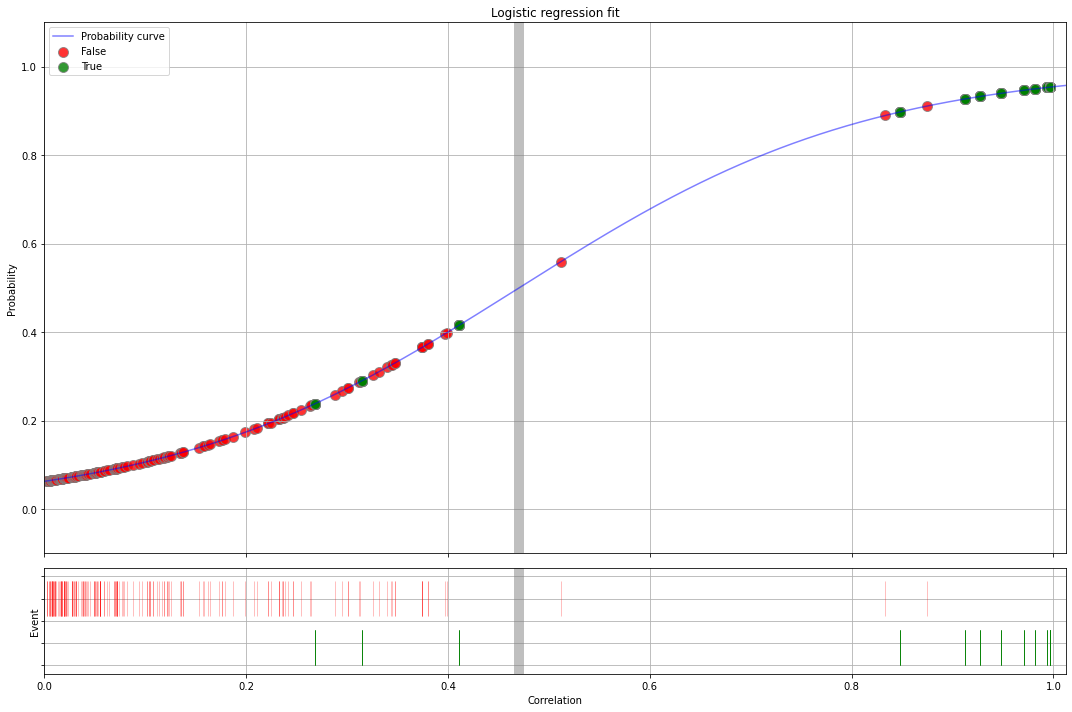

Limit at 0.47
Performance report
--------------------------------------------------
True positive: 90 -- False negative: 30
True negative: 187 -- False positive: 3

Precision score: 0.9677
Recall score: 0.7500
F1 score: 0.8451


In [17]:
sc.make_logreg_fit(similar_corr, nonsimilar_corr, 
                labels=('Correlation', 'Probability'), limits=(0,0.92))

summary.update({'correl_2':
           sc.performance_report(similar_corr, nonsimilar_corr, limit=0.47)})

## For average hashing (cv2)

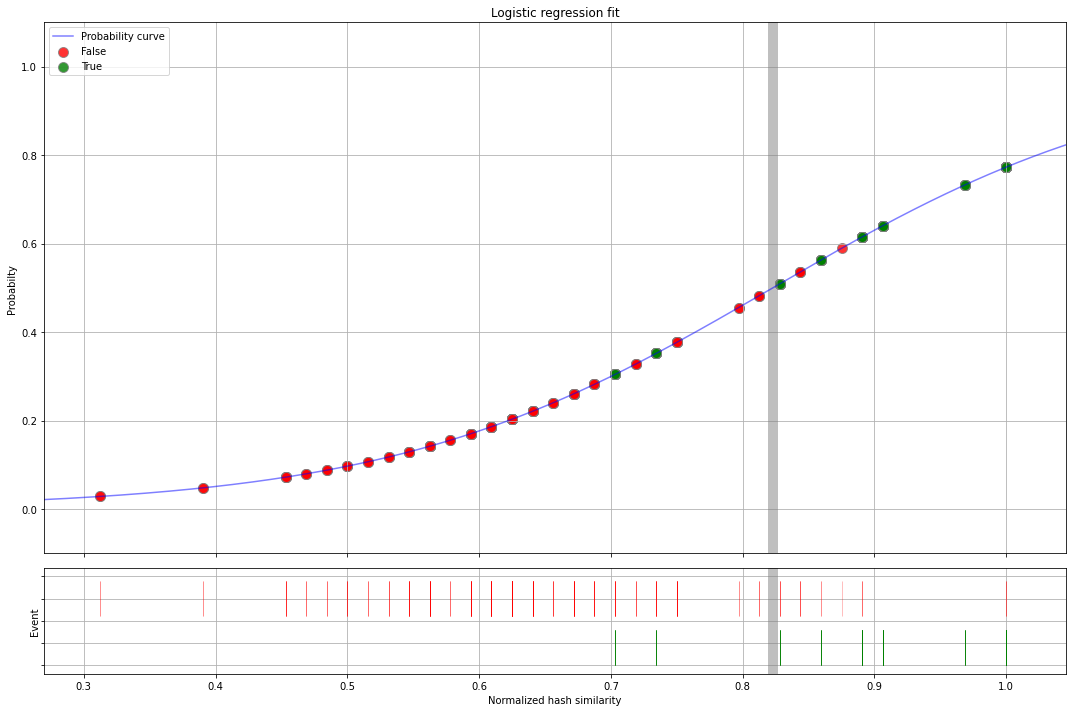

Limit at 0.82
Performance report
--------------------------------------------------
True positive: 100 -- False negative: 20
True negative: 173 -- False positive: 17

Precision score: 0.8547
Recall score: 0.8333
F1 score: 0.8439


In [18]:
sc.make_logreg_fit(similar_hash_avg, nonsimilar_hash_avg, 
                   labels=('Normalized hash similarity', 'Probabilty'), limits=(0.3, 0.95))

summary.update({'avg_hash_2':
            sc.performance_report(similar_hash_avg, nonsimilar_hash_avg, limit=0.82)})

## For block mean hashing

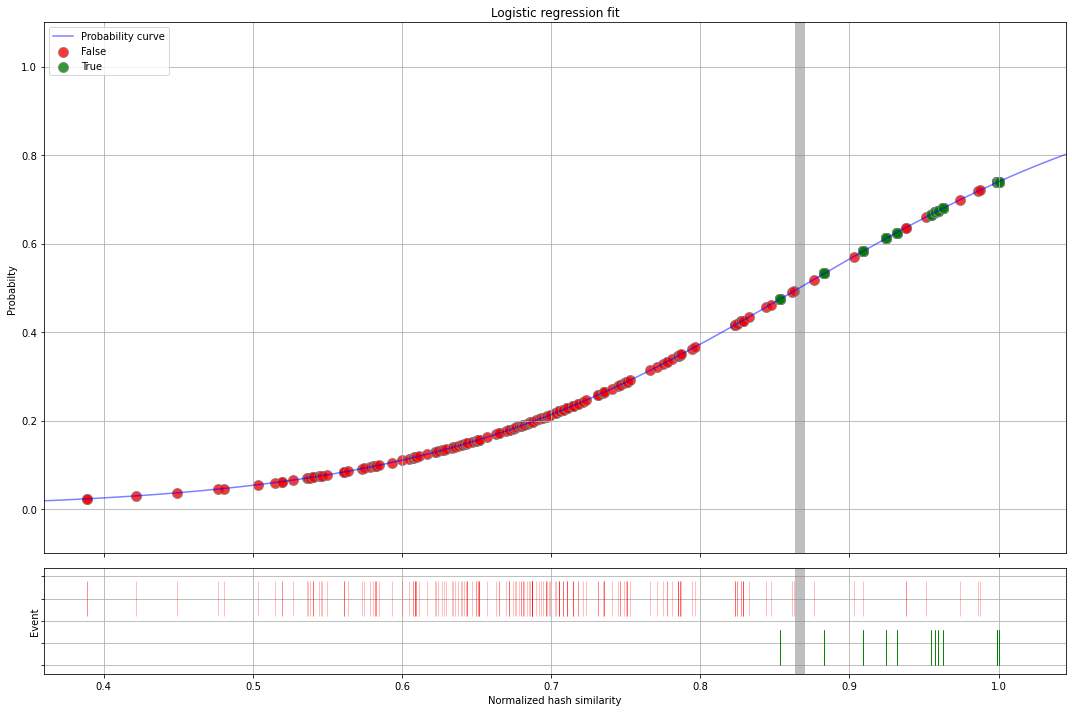

Limit at 0.87
Performance report
--------------------------------------------------
True positive: 110 -- False negative: 10
True negative: 181 -- False positive: 9

Precision score: 0.9244
Recall score: 0.9167
F1 score: 0.9205


In [19]:
sc.make_logreg_fit(similar_hash_block, nonsimilar_hash_block, 
                   labels=('Normalized hash similarity', 'Probabilty'), limits=(0.4, 0.95))

summary.update({'block_hash_2':
            sc.performance_report(similar_hash_block, nonsimilar_hash_block, limit=0.87)})

## For perceptual hashing

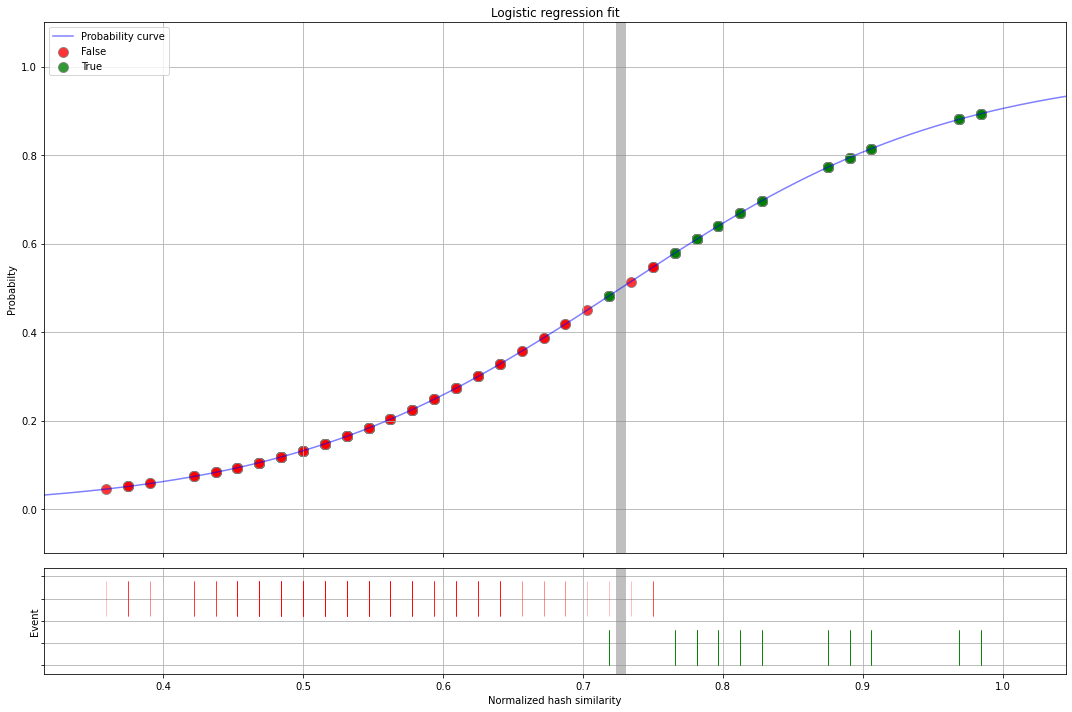

Limit at 0.73
Performance report
--------------------------------------------------
True positive: 110 -- False negative: 10
True negative: 185 -- False positive: 5

Precision score: 0.9565
Recall score: 0.9167
F1 score: 0.9362


In [20]:
sc.make_logreg_fit(similar_hash_p, nonsimilar_hash_p, 
                   labels=('Normalized hash similarity', 'Probabilty'), limits=(0.35, 0.95))

summary.update({'p_hash_2':
            sc.performance_report(similar_hash_p, nonsimilar_hash_p, limit=0.73)})

## For Marr Hildreth hashing

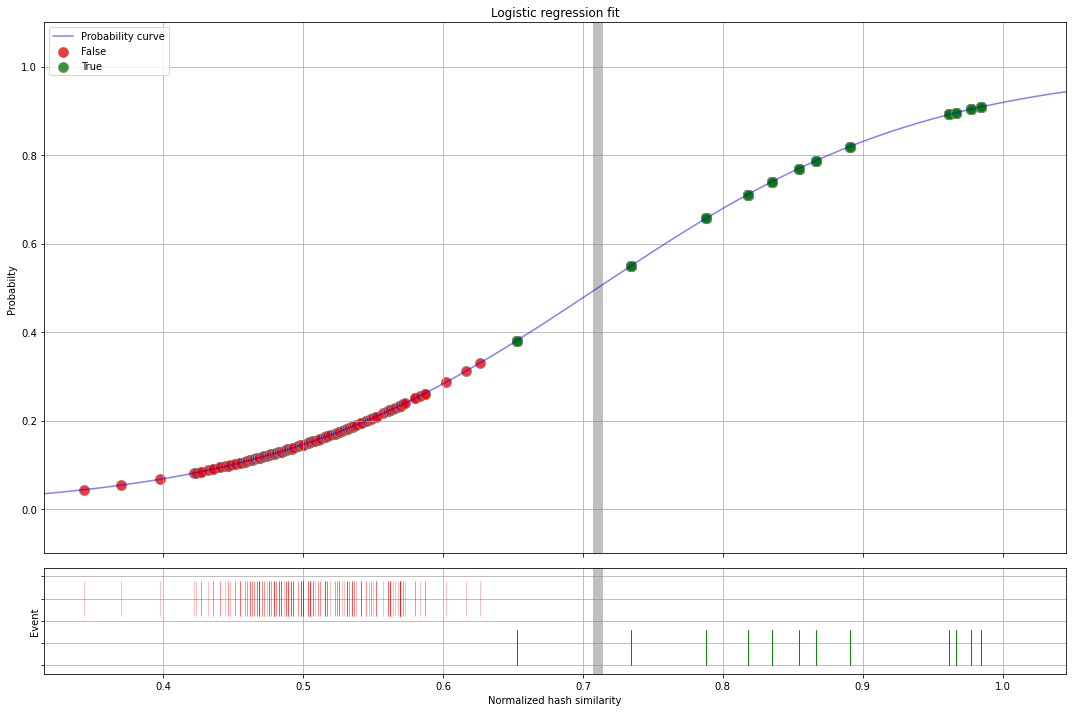

Limit at 0.71
Performance report
--------------------------------------------------
True positive: 110 -- False negative: 10
True negative: 190 -- False positive: 0

Precision score: 1.0000
Recall score: 0.9167
F1 score: 0.9565


In [21]:
sc.make_logreg_fit(similar_hash_mh, nonsimilar_hash_mh, 
                   labels=('Normalized hash similarity', 'Probabilty'), limits=(0.35, 0.95))

summary.update({'marrhildreth_hash_2':
            sc.performance_report(similar_hash_mh, nonsimilar_hash_mh, limit=0.71)})

## For radial variance hashing

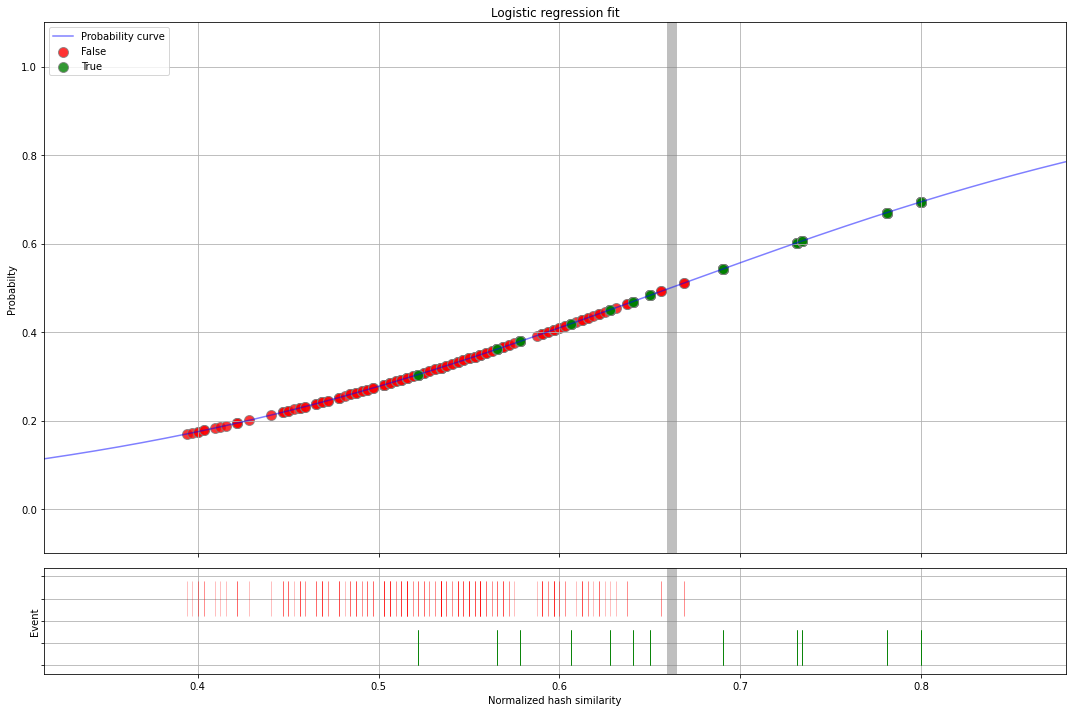

Limit at 0.66
Performance report
--------------------------------------------------
True positive: 50 -- False negative: 70
True negative: 188 -- False positive: 2

Precision score: 0.9615
Recall score: 0.4167
F1 score: 0.5814


In [22]:
sc.make_logreg_fit(similar_hash_rv, nonsimilar_hash_rv, 
                   labels=('Normalized hash similarity', 'Probabilty'), limits=(0.35, 0.8))

summary.update({'radialvariance_hash_2':
            sc.performance_report(similar_hash_rv, nonsimilar_hash_rv, limit=0.66)})

# Evaluation of methods

In [23]:
summary = pd.DataFrame().from_dict(summary, orient='index',
                        columns=['precision', 'recall', 'f1'])
summary
#1: mean value
#2: logistic regression

,precision,recall,f1
hash_1,0.909091,0.500000,0.645161
hash_adv_1,0.911765,0.516667,0.659574
bhattacharyya_1,1.000000,0.500000,0.666667
correl_1,0.978261,0.750000,0.849057
avg_hash_1,0.930233,0.666667,0.776699
block_hash_1,0.945946,0.583333,0.721649
perceptual_hash_1,1.000000,0.416667,0.588235
marrhildreth_hash_1,1.000000,0.500000,0.666667
radialvariance_hash_1,0.961538,0.416667,0.581395
hash_2,0.833333,0.750000,0.789474


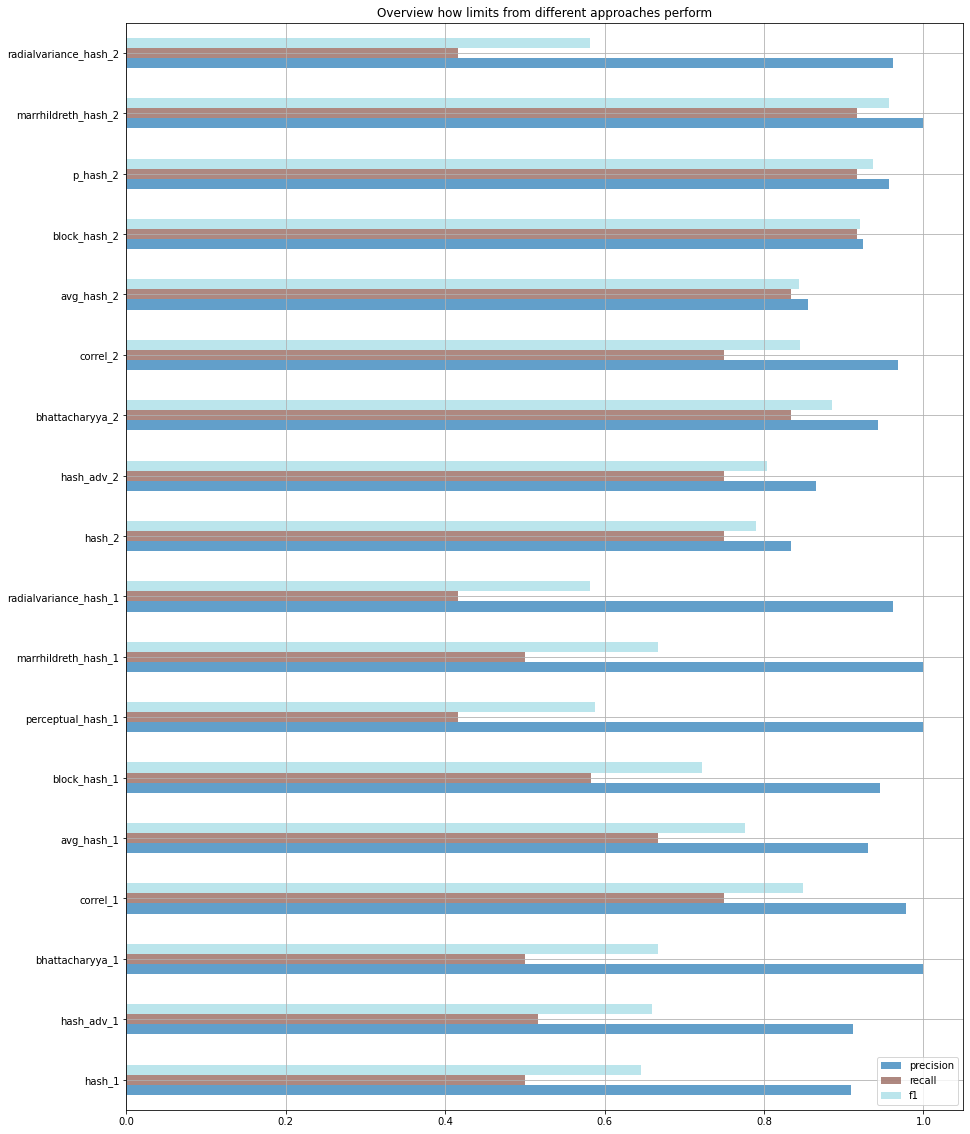

In [24]:
summary.plot.barh(alpha=0.7, figsize=(15, 20), grid=True, legend=True, 
                  title='Overview how limits from different approaches perform',
                  colormap='tab20')

# taking the mean for the limits seems to make conservative distinctions
# the limits from logistic regression fits seem to yield better balanced
# results (f1-score)

# For our images, the winning algorithms are:
# Marr Hildreth, Perceptual Hash and Block Mean Hash
# with limit estimates based on Logistic Regression